In [8]:
import json
import os
import math
import librosa

DATASET_PATH = "/Users/mohammad/Desktop/master/audio"
JSON_PATH = "data.json"
SAMPLE_RATE = 44100
TRACK_DURATION = 5 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=2):
    """Extracts MFCCs from dataset and saves them into a json file along witgh specific labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
 
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=2)


Processing: helicopter
/Users/mohammad/Desktop/master/audio/helicopter/5-177957-D-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/5-177957-D-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/2-188822-A-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/2-188822-A-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/3-68630-A-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/3-68630-A-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/4-125929-A-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/4-125929-A-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/3-68630-C-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/3-68630-C-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/1-172649-B-40.wav, segment:1
/Users/mohammad/Desktop/master/audio/helicopter/1-172649-B-40.wav, segment:2
/Users/mohammad/Desktop/master/audio/helicopter/2-188822

/Users/mohammad/Desktop/master/audio/airplane/3-128512-B-47.wav, segment:2
/Users/mohammad/Desktop/master/audio/airplane/5-251963-A-47.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/5-251963-A-47.wav, segment:2
/Users/mohammad/Desktop/master/audio/airplane/5-251962-A-47.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/5-251962-A-47.wav, segment:2
/Users/mohammad/Desktop/master/audio/airplane/404127__hali-pinson__airplane-engine.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/4-161099-B-47.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/4-161099-B-47.wav, segment:2
/Users/mohammad/Desktop/master/audio/airplane/3-143562-A-47.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/3-143562-A-47.wav, segment:2
/Users/mohammad/Desktop/master/audio/airplane/208854__insestanyricarda__avio.wav, segment:1
/Users/mohammad/Desktop/master/audio/airplane/208854__insestanyricarda__avio.wav, segment:2
/Users/mohammad/Desktop/master/audio/airpla

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # build network topology
    model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu'),

        # output layer
        keras.layers.Dense(11, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Data succesfully loaded!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2808)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1438208   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          

Epoch 49/100
6/6 [==============================] - 0s 15ms/step - loss: 5.9185 - accuracy: 0.6526 - val_loss: 2.3390 - val_accuracy: 0.6316
Epoch 50/100
6/6 [==============================] - 0s 20ms/step - loss: 5.9207 - accuracy: 0.7188 - val_loss: 2.1409 - val_accuracy: 0.6316
Epoch 51/100
6/6 [==============================] - 0s 19ms/step - loss: 5.8903 - accuracy: 0.6555 - val_loss: 2.1994 - val_accuracy: 0.5789
Epoch 52/100
6/6 [==============================] - 0s 26ms/step - loss: 6.9601 - accuracy: 0.6025 - val_loss: 2.1685 - val_accuracy: 0.5789
Epoch 53/100
6/6 [==============================] - 0s 26ms/step - loss: 5.6396 - accuracy: 0.6251 - val_loss: 2.1424 - val_accuracy: 0.6316
Epoch 54/100
6/6 [==============================] - 0s 20ms/step - loss: 6.3098 - accuracy: 0.6627 - val_loss: 1.9206 - val_accuracy: 0.5789
Epoch 55/100
6/6 [==============================] - 0s 25ms/step - loss: 6.2389 - accuracy: 0.6642 - val_loss: 2.2055 - val_accuracy: 0.5789
Epoch 56/100


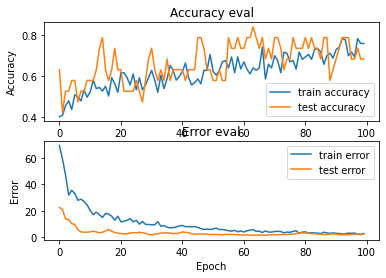

In [4]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(3, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

    # plot accuracy and error as a function of the epochs
    plot_history(history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 1, 32)        

6/6 [==============================] - 0s 61ms/step - loss: 0.0865 - accuracy: 0.9881 - val_loss: 0.4019 - val_accuracy: 0.8889
Epoch 103/110
6/6 [==============================] - 0s 67ms/step - loss: 0.0691 - accuracy: 0.9948 - val_loss: 0.3727 - val_accuracy: 0.8889
Epoch 104/110
6/6 [==============================] - 1s 75ms/step - loss: 0.1190 - accuracy: 0.9746 - val_loss: 0.4016 - val_accuracy: 0.8889
Epoch 105/110
6/6 [==============================] - 1s 108ms/step - loss: 0.0583 - accuracy: 1.0000 - val_loss: 0.5024 - val_accuracy: 0.8889
Epoch 106/110
6/6 [==============================] - 0s 79ms/step - loss: 0.0597 - accuracy: 0.9966 - val_loss: 0.5039 - val_accuracy: 0.7778
Epoch 107/110
6/6 [==============================] - 0s 62ms/step - loss: 0.0577 - accuracy: 0.9926 - val_loss: 0.4179 - val_accuracy: 0.7778
Epoch 108/110
6/6 [==============================] - 0s 59ms/step - loss: 0.0734 - accuracy: 0.9974 - val_loss: 0.3536 - val_accuracy: 0.7778
Epoch 109/110
6/6 [

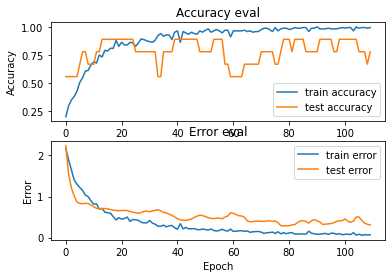

1/1 - 0s - loss: 0.8350 - accuracy: 0.8000

Test accuracy: 0.800000011920929
Target: 0, Predicted label: [0]


In [14]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def prepare_datasets(test_size, validation_size):
    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(4, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.05, 0.05)
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
#     X_train = X_train / 255
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=110)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[1]
    y_to_predict = y_test[1]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [11]:
# Save the model as a file
from tensorflow.keras import models
models.save_model(model, 'final-model.h5')